In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("DataAnalysis") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

data = spark.read.csv('hypothesis_testing_data.csv', header=True, inferSchema=True)

data.show()

data.head()


+------------------+------------------+---+
|            Salary|        ExamScores|Age|
+------------------+------------------+---+
| 59967.14153011233|53.769438869243785| 19|
| 53617.35698828816| 68.69032015851961| 43|
| 61476.88538100693| 69.85928225209845| 34|
| 70230.29856408025| 62.96584096167572| 57|
| 52658.46625276664| 72.58071432500986| 50|
|52658.630430508194| 81.06076285221808| 26|
| 70792.12815507391|103.29278851815795| 60|
| 62674.34729152909| 77.61866719247759| 65|
| 50305.25614065048| 78.86325586084146| 56|
| 60425.60043585965|  73.8833112635075| 46|
| 50365.82307187538| 46.21843177051438| 59|
| 50342.70246429743| 74.60229186826174| 43|
| 57419.62271566034| 75.90345314911539| 52|
|35867.197553422026|111.94863168727929| 42|
| 37750.82167486967| 72.11458552828316| 41|
| 49377.12470759027| 79.52321013500419| 30|
| 44871.68879665576| 74.47932345442135| 24|
| 58142.47332595274| 57.46982943570702| 53|
| 45919.75924478789| 92.14234221772531| 62|
|40876.962986647086| 86.27899549

Row(Salary=59967.14153011233, ExamScores=53.769438869243785, Age=19)

In [11]:
from pyspark.sql.functions import *
missing_values = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
missing_values.show()


+------+----------+---+
|Salary|ExamScores|Age|
+------+----------+---+
|     0|         0|  0|
+------+----------+---+



In [12]:
from pyspark.sql.functions import mean

for column in data.columns:
    if dict(data.dtypes)[column] in ['int', 'double']:
        mean_value = data.select(mean(col(column))).collect()[0][0]
        data = data.fillna({column: mean_value})

data = data.dropna()


In [13]:
data.show()

+------------------+------------------+---+
|            Salary|        ExamScores|Age|
+------------------+------------------+---+
| 59967.14153011233|53.769438869243785| 19|
| 53617.35698828816| 68.69032015851961| 43|
| 61476.88538100693| 69.85928225209845| 34|
| 70230.29856408025| 62.96584096167572| 57|
| 52658.46625276664| 72.58071432500986| 50|
|52658.630430508194| 81.06076285221808| 26|
| 70792.12815507391|103.29278851815795| 60|
| 62674.34729152909| 77.61866719247759| 65|
| 50305.25614065048| 78.86325586084146| 56|
| 60425.60043585965|  73.8833112635075| 46|
| 50365.82307187538| 46.21843177051438| 59|
| 50342.70246429743| 74.60229186826174| 43|
| 57419.62271566034| 75.90345314911539| 52|
|35867.197553422026|111.94863168727929| 42|
| 37750.82167486967| 72.11458552828316| 41|
| 49377.12470759027| 79.52321013500419| 30|
| 44871.68879665576| 74.47932345442135| 24|
| 58142.47332595274| 57.46982943570702| 53|
| 45919.75924478789| 92.14234221772531| 62|
|40876.962986647086| 86.27899549

In [21]:
# Summary statistics
data.describe().show()
# Show column names
print(data.columns)

# Count of rows and columns
print(f"Rows: {data.count()}, Columns: {len(data.columns)}")


+-------+------------------+------------------+------------------+
|summary|            Salary|        ExamScores|               Age|
+-------+------------------+------------------+------------------+
|  count|               100|               100|               100|
|   mean|53961.534826059054|  75.3345688057489|             41.93|
| stddev| 9081.684280078009|14.305034492746552|14.024693230228609|
|    min|28802.548959102558| 46.21843177051438|                18|
|    max| 73522.78184508938|115.80253749884429|                65|
+-------+------------------+------------------+------------------+

['Salary', 'ExamScores', 'Age']
Rows: 100, Columns: 3


In [27]:
# Replace 'CategoricalColumn' with an actual column name, if any
grouped_data = data.groupBy("Salary").mean()
grouped_data.show(5)


+-----------------+-----------------+-----------------+--------+
|           Salary|      avg(Salary)|  avg(ExamScores)|avg(Age)|
+-----------------+-----------------+-----------------+--------+
|62674.34729152909|62674.34729152909|77.61866719247759|    65.0|
|35403.29876120224|35403.29876120224|70.16907725691486|    59.0|
|49702.39796232961|49702.39796232961|62.29809422897392|    33.0|
|65309.99522495951|65309.99522495951|79.39608709948021|    52.0|
|37369.59844637266|37369.59844637266|79.45477009849779|    23.0|
+-----------------+-----------------+-----------------+--------+
only showing top 5 rows



In [28]:

print(data.columns)


['Salary', 'ExamScores', 'Age']


In [34]:
# Convert to Pandas for hypothesis testing
pandas_data = data.toPandas()

from statsmodels.multivariate.manova import MANOVA

manova = MANOVA.from_formula('ExamScores + Age ~ Salary', data=pandas_data)
print(manova.mv_test())




                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.4688 2.0000 97.0000 54.9563 0.0000
         Pillai's trace 0.5312 2.0000 97.0000 54.9563 0.0000
 Hotelling-Lawley trace 1.1331 2.0000 97.0000 54.9563 0.0000
    Roy's greatest root 1.1331 2.0000 97.0000 54.9563 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
         Salary         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9609 2.0000 97.0000  1.9743 0.1444
         Pillai's trace 0.0391 2.0000 97.0000  1.9743 0.1444
 Hotelling-Lawley trace 0.0407 2.0000 97.0

In [31]:
print(data.columns)

['Salary', 'ExamScores', 'Age']


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X = pandas_data[['Age', 'ExamScores']]  # Features (independent variables)
y = pandas_data['Salary']  # Target (dependent variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create a Linear Regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared (goodness of fit)

# Print the evaluation results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 6228.83414454147
Mean Squared Error (MSE): 65722909.10799066
R-squared (R2): -0.06071942187642354


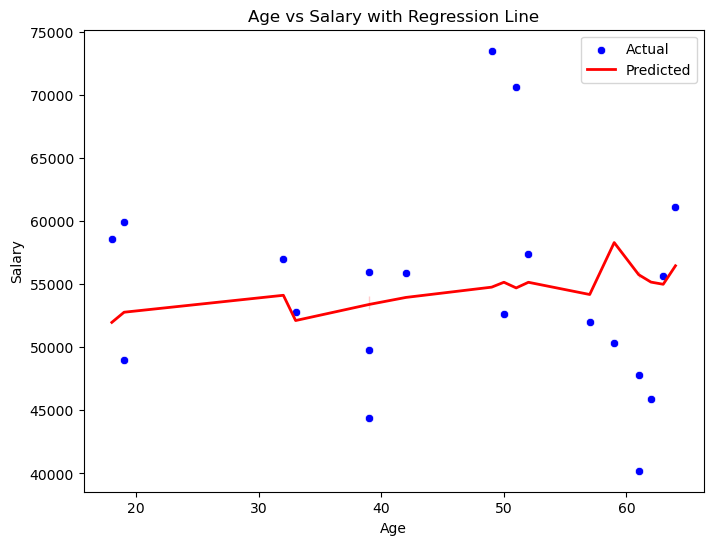

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test['Age'], y=y_test, color='blue', label='Actual')
sns.lineplot(x=X_test['Age'], y=y_pred, color='red', label='Predicted', linewidth=2)

plt.title("Age vs Salary with Regression Line")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.legend()
plt.show()


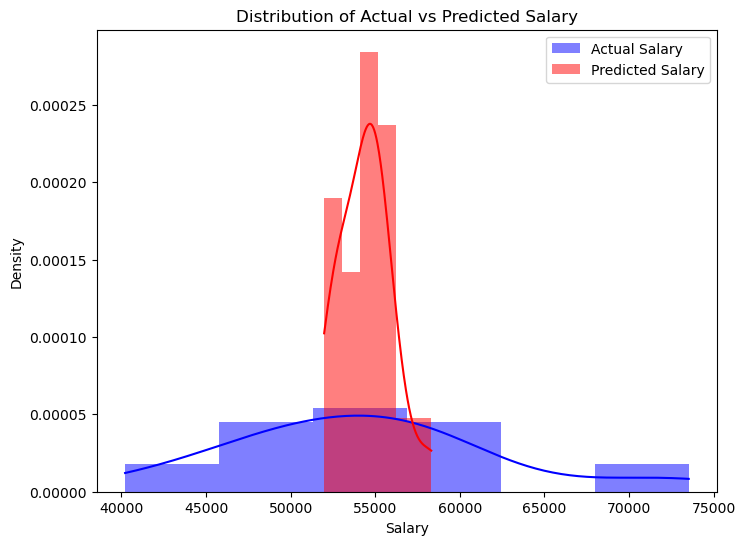

In [40]:
plt.figure(figsize=(8, 6))

# Plot the distribution of actual vs predicted salary
sns.histplot(y_test, color='blue', kde=True, label='Actual Salary', stat='density', linewidth=0)
sns.histplot(y_pred, color='red', kde=True, label='Predicted Salary', stat='density', linewidth=0)

# Adding labels and title
plt.title("Distribution of Actual vs Predicted Salary")
plt.xlabel("Salary")
plt.ylabel("Density")
plt.legend()
plt.show()


In [45]:
print(data.columns)

['Salary', 'ExamScores', 'Age']
